In [1]:
# importing basic packages
import pandas as pd
import numpy as np

* The data consists of 2 csv files :
    * One csv called "features" has all the predictor variables
    * The other csv called "labels" has the unique ID and response variable
<br><br/>

* **Data Pre-processing :**
    * Step 1 : Creating Test, Validation and Train splits
        * Merge sheets "features" and "labels"
        * Look for % of row split by response variable
        * Correct class imbalance if exists
        * Randomize the dataset and apply split method to create train, validation and test datasets


In [2]:
# merging sheets
# sheet containing feature data
df_f = pd.read_csv('features.csv')

In [3]:
# merging sheets
# sheet containing labels data
df_l = pd.read_csv('labels.csv')

In [4]:
# merge the two to get complete dataset
df_full = pd.merge(df_f,df_l,on='id')

In [5]:
df_full.shape

(59400, 41)

In [6]:
df_full.head(1)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional


In [7]:
# checking for row count per level of response variable
df_full['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

### Please note :
* We see that the category **"functional needs repair"** forms a minor 7% of total data
* Also, to limit the problem to that of a "binary classification problem", we would get rid of the rows belonging to this category

In [8]:
# creating a reduced dataset by removing rows pertaining to the class = "functional needs repair"
df_redc = df_full[df_full['status_group'] != 'functional needs repair']

In [9]:
df_redc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55083 entries, 0 to 59399
Data columns (total 41 columns):
id                       55083 non-null int64
amount_tsh               55083 non-null float64
date_recorded            55083 non-null object
funder                   51885 non-null object
gps_height               55083 non-null int64
installer                51868 non-null object
longitude                55083 non-null float64
latitude                 55083 non-null float64
wpt_name                 55083 non-null object
num_private              55083 non-null int64
basin                    55083 non-null object
subvillage               54713 non-null object
region                   55083 non-null object
region_code              55083 non-null int64
district_code            55083 non-null int64
lga                      55083 non-null object
ward                     55083 non-null object
population               55083 non-null int64
public_meeting           51905 non-null object
r

In [10]:
df_redc.shape

(55083, 41)

In [11]:
# randomize the data and separate out the test dataset
from sklearn.utils import shuffle
df_redc = shuffle(df_redc)
test = df_redc[:5000]
train = df_redc[5000:]
# save test data as a csv which will be used only to evaluate the model in the end
test[['id','status_group']].to_csv('test.csv',index=False)

### Next Step :
* Now, since the dataset consists of only two classes, let's check the class imbalance scenario

In [12]:
train.status_group.value_counts()

functional        29280
non functional    20803
Name: status_group, dtype: int64

In [13]:
train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [14]:
# There are a no. of columns with missing data.All are categorical
# scheme name column has almost 50% data missing. Hence, we drop it
train = train.drop('scheme_name',axis = 1)

In [15]:
# selecting all categorical features
feature_cols = train.select_dtypes('object').columns

In [16]:
# selecting all numeric features
num_cols = train.select_dtypes('int64').columns

In [17]:
print(len(feature_cols))
print(len(num_cols))

30
7


In [18]:
# Let's do a bit of feature engineering and create a column called age (age of the pump since construction)
train['year_recorded'] = train['date_recorded'].apply(lambda x: int(x.strip().split('-')[0]))
train['handpump_age'] = train['year_recorded'] - train['construction_year']
train.loc[train['handpump_age']==train['year_recorded'],['handpump_age']] = np.nan

### Missing value treatment :
* 35% of handpump data is missing
* I'll use the below strategy to treat missing values
    * Find district wise average age of the pumps and replace the missing values with the same

In [19]:
df_p1 = train.loc[~train['handpump_age'].isna()]

In [20]:
df_p2 = train.loc[train['handpump_age'].isna()]

In [21]:
df_p3 = train.groupby('district_code')['handpump_age'].agg(np.mean).to_frame()

In [22]:
df_p4 = pd.merge(df_p2,df_p3,on='district_code')

In [23]:
df_p4 = df_p4.drop('handpump_age_y',axis = 1)

In [24]:
df_p4 = df_p4.rename(columns = {"handpump_age_x": "handpump_age"}) 

In [25]:
train = pd.concat([df_p1,df_p4])

In [26]:
train[feature_cols] = train[feature_cols].fillna(np.nan)

In [27]:
# removing all the rows having null values for handpump_age
df_final = train[~train['handpump_age'].isna()]

In [28]:
# dropping variables which have either too many levels or seem to be of no use
df_final = df_final.drop(['wpt_name','date_recorded','installer','subvillage','funder','latitude','longitude','gps_height','ward',],axis=1)

### Outlier Treatment
* We'll analyze two of the numeric features i.e amount_tsh and handpump_age for outliers and treat them accordingly

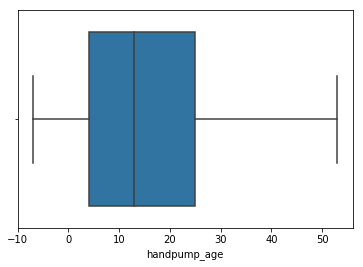

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.boxplot(df_final['handpump_age'])

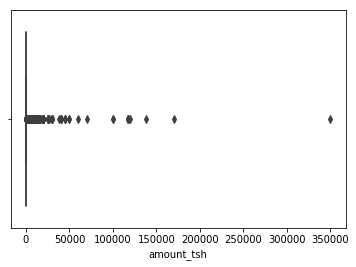

In [35]:
sns.boxplot(df_final['amount_tsh'])

In [36]:
from numpy import percentile
Q1 = df_final['amount_tsh'].quantile(0.25)

In [37]:
Q3 = df_final['amount_tsh'].quantile(0.75)

In [38]:
IQR = Q3-Q1

In [39]:
lower_band = 0 if Q1 - 1.5*IQR <= 0 else Q1 - 1.5*IQR
upper_band = Q3 + 1.5*IQR

In [40]:
lower_band,upper_band

(0, 500.0)

In [41]:
df_final['amount_tsh'] = df_final['amount_tsh'].clip(lower = lower_band, upper = upper_band)

### Exploratory Data Analysis

### Hypotheses to test :
* Now, since we have a clean data, let's do some EDA
* I have formulated several hypotheses which I'll explore during the EDA phase :
    * The older the pump, the higher the chance of damage
    * The higher the population of the location, the higher the usage of the pump, thus higher the chance of damage
    * Water Quality may have an impact. Salty water may lead to internal rusting of the pump hence leading to possible damage
    * The installer company may show some impact (A given company may manufacture inferior quality pumps compared to others)
    * Funder, Installer, Lat-Long, Source, Region may not have any impact on the defectiveness of the pump
<br><br/>
#### Let's analyze the dataset based on the above stated hypotheses!

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

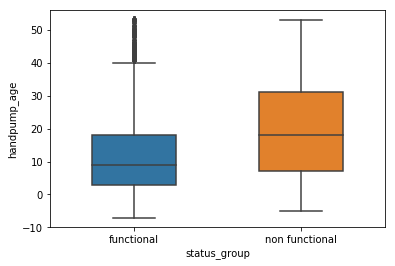

In [43]:
sns.boxplot( x=df_final["status_group"], y=df_final["handpump_age"], width = 0.5)

### Conclusion : 
* It seems functional pumps distribution is negatively skewed and that of non-functional pumps is positively skewed
* It appears that age does have an impact on degree of damage to the pumps

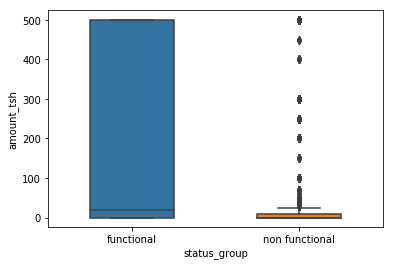

In [44]:
sns.boxplot( x=df_final["status_group"], y=df_final["amount_tsh"], width = 0.5)

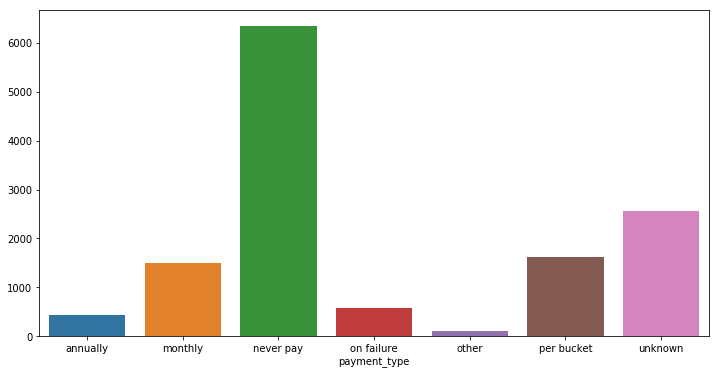

In [45]:
# visualizing defective status by payment_type
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6))
y = df_final[df_final['status_group']=='non functional'].groupby(['payment_type'])['id'].agg(np.size).values
x = df_final[df_final['status_group']=='non functional'].groupby(['payment_type'])['id'].agg(np.size).index
sns.barplot(x=x, y=y, data=df_final)

### Conclusion : 
* It appears that a majority of handpumps are non-functional since the payment (could be some fee or maintenance charges) has never been made. Payment type may have an impact on the response variable

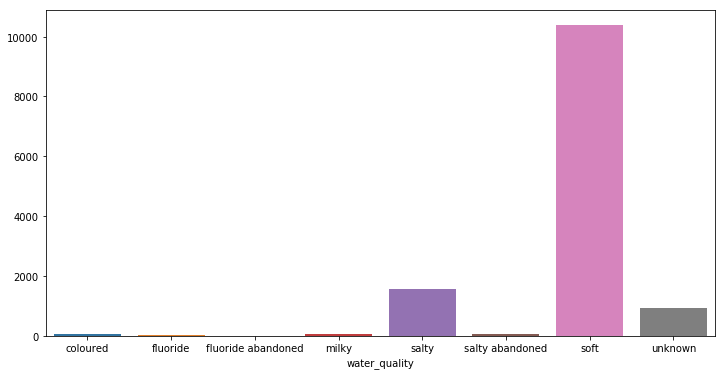

In [46]:
# visualizing defective status by water_quality
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6))
y = df_final[df_final['status_group']=='non functional'].groupby(['water_quality'])['id'].agg(np.size).values
x = df_final[df_final['status_group']=='non functional'].groupby(['water_quality'])['id'].agg(np.size).index
sns.barplot(x=x, y=y, data=df_final)

### Conclusion : 
* It appears that "soft" water leads to defective hand pumps in majority of the cases.While looking for the cause of this, I got to read the following article [here](https://curaflo.com/soft-water/). This shows quality of water can lead to corrosion of pipes in a big way

In [47]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32877 entries, 10996 to 21598
Data columns (total 33 columns):
id                       32877 non-null int64
amount_tsh               32877 non-null float64
num_private              32877 non-null int64
basin                    32877 non-null object
region                   32877 non-null object
region_code              32877 non-null int64
district_code            32877 non-null int64
lga                      32877 non-null object
population               32877 non-null int64
public_meeting           30893 non-null object
recorded_by              32877 non-null object
scheme_management        30757 non-null object
permit                   31258 non-null object
construction_year        32877 non-null int64
extraction_type          32877 non-null object
extraction_type_group    32877 non-null object
extraction_type_class    32877 non-null object
management               32877 non-null object
management_group         32877 non-null object

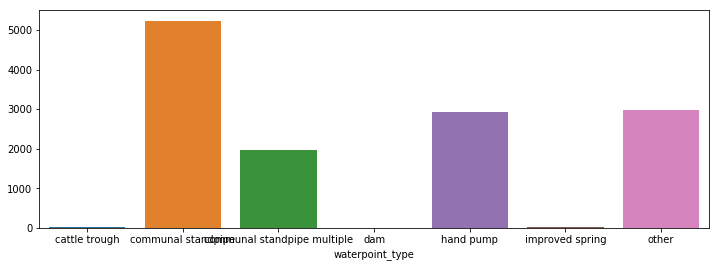

In [48]:
# visualizing defective status by waterpoint type
from matplotlib.pyplot import figure
figure(num=None, figsize=(12,4))
y = df_final[df_final['status_group']=='non functional'].groupby(['waterpoint_type'])['id'].agg(np.size).values
x = df_final[df_final['status_group']=='non functional'].groupby(['waterpoint_type'])['id'].agg(np.size).index
sns.barplot(x=x, y=y, data=df_final)

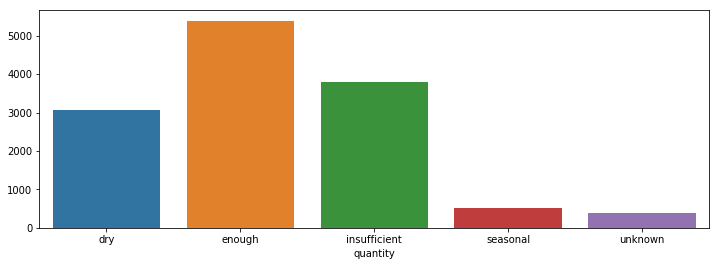

In [49]:
# visualizing defective status by quantity
from matplotlib.pyplot import figure
figure(num=None, figsize=(12,4))
y = df_final[df_final['status_group']=='non functional'].groupby(['quantity'])['id'].agg(np.size).values
x = df_final[df_final['status_group']=='non functional'].groupby(['quantity'])['id'].agg(np.size).index
sns.barplot(x=x, y=y, data=df_final)

### Conclusion : 
* Can't say conclusively whether source of water has any impact on the extent of damage to the hand pump

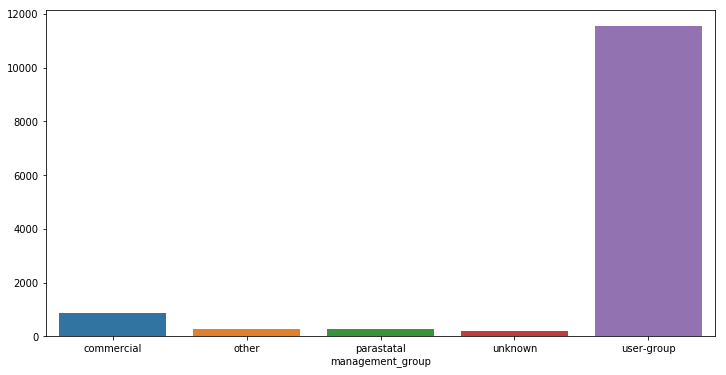

In [50]:
# visualizing defective status by management_group
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6))
y = df_final[df_final['status_group']=='non functional'].groupby(['management_group'])['id'].agg(np.size).values
x = df_final[df_final['status_group']=='non functional'].groupby(['management_group'])['id'].agg(np.size).index
sns.barplot(x=x, y=y, data=df_final)

### Conclusion : 
* It is evident that the hand pumps managed by user groups are more prone to damage (may be due to negligience)

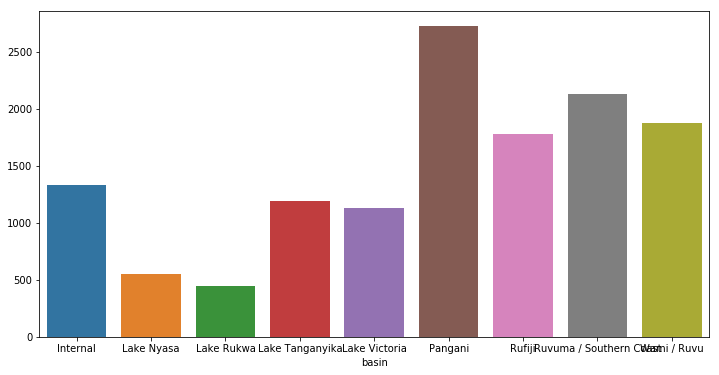

In [51]:
# visualizing defective status by payment_type
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6))
y = df_final[df_final['status_group']=='non functional'].groupby(['basin'])['id'].agg(np.size).values
x = df_final[df_final['status_group']=='non functional'].groupby(['basin'])['id'].agg(np.size).index
sns.barplot(x=x, y=y, data=df_final)

### Conclusion : 
* It seems nothing can be said conclusively about the impact of type of basin on hand pump damage

In [52]:
df_final = df_final.drop(['num_private','lga','construction_year'
                          ,'extraction_type','extraction_type_group','management'
                         ,'source_type','quality_group','quantity_group'
                         ,'waterpoint_type_group','year_recorded'],axis=1)

In [53]:
# let's look at the no. of levels for each categorical variable
df_final.head()

,id,amount_tsh,basin,region,region_code,district_code,population,public_meeting,recorded_by,scheme_management,...,management_group,payment,payment_type,water_quality,quantity,source,source_class,waterpoint_type,status_group,handpump_age
10996,38228,10.0,Pangani,Kilimanjaro,3,5,15,True,GeoData Consultants Ltd,Water Board,...,user-group,pay per bucket,per bucket,soft,enough,spring,groundwater,communal standpipe,functional,14.0
10402,12371,0.0,Rufiji,Iringa,11,4,112,True,GeoData Consultants Ltd,VWC,...,user-group,pay when scheme fails,on failure,soft,insufficient,spring,groundwater,communal standpipe,functional,2.0
15371,25801,0.0,Pangani,Kilimanjaro,3,4,1,False,GeoData Consultants Ltd,Parastatal,...,parastatal,never pay,never pay,soft,enough,spring,groundwater,communal standpipe,functional,45.0
15925,49974,50.0,Lake Nyasa,Ruvuma,10,2,300,True,GeoData Consultants Ltd,VWC,...,user-group,pay per bucket,per bucket,soft,dry,shallow well,groundwater,hand pump,non functional,13.0
44995,50441,0.0,Wami / Ruvu,Pwani,6,1,40,True,GeoData Consultants Ltd,Company,...,user-group,never pay,never pay,soft,enough,river,surface,communal standpipe,non functional,19.0


In [54]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32877 entries, 10996 to 21598
Data columns (total 22 columns):
id                       32877 non-null int64
amount_tsh               32877 non-null float64
basin                    32877 non-null object
region                   32877 non-null object
region_code              32877 non-null int64
district_code            32877 non-null int64
population               32877 non-null int64
public_meeting           30893 non-null object
recorded_by              32877 non-null object
scheme_management        30757 non-null object
permit                   31258 non-null object
extraction_type_class    32877 non-null object
management_group         32877 non-null object
payment                  32877 non-null object
payment_type             32877 non-null object
water_quality            32877 non-null object
quantity                 32877 non-null object
source                   32877 non-null object
source_class             32877 non-null obje

In [55]:
final_feat_cols = df_final.select_dtypes('object').columns

### Discussion on Exploratory Data Analysis :

### Next Step : 
* With a fair bit of understanding of the potential factors leading to defective pumps, let's get into actual modelling and see how better the machine predicts

In [56]:
# let's split the train data further into features and labels
df_final['status_group'] = df_final['status_group'].map({'non functional': 1, 'functional': 0})

In [57]:
df_final[final_feat_cols] = df_final[final_feat_cols].fillna('N/A')

In [58]:
df_final['public_meeting'] = df_final['public_meeting'].map({'True': 1, 'False': 0, 'N/A': 0})
df_final['permit'] = df_final['permit'].map({'True': 1, 'False': 0, 'N/A': 0})

In [59]:
# label encoding categorical features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_final = df_final.apply(LabelEncoder().fit_transform)

In [60]:
# splitting the feature and response variables
X = df_final.loc[:,df_final.columns != 'status_group']
y = df_final['status_group']

In [63]:
# creating the train and validation split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [64]:
X_train.columns

Index(['id', 'amount_tsh', 'basin', 'region', 'region_code', 'district_code',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'permit', 'extraction_type_class', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quantity', 'source', 'source_class',
       'waterpoint_type', 'handpump_age'],
      dtype='object')

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,fbeta_score

In [71]:
# pass 1 : Logistic Regression
model1 = LogisticRegression()

In [77]:
model1.fit(X_train,y_train)
y_pred = model1.predict(X_test)
print("The accuracy score of Logistic Regression model is %s" %(accuracy_score(y_test,y_pred)))
print("The fbeta score of Logistic Regression model is %s" %(fbeta_score(y_test,y_pred,beta=0.5)))

The accuracy score of Logistic Regression model is 0.7272911597729116
The fbeta score of Logistic Regression model is 0.6645841691981429


In [78]:
model2 = DecisionTreeClassifier()
model2.fit(X_train,y_train)
y_pred = model2.predict(X_test)
print("The accuracy score of DecisionTreeClassifier model is %s" %(accuracy_score(y_test,y_pred)))
print("The fbeta score of DecisionTreeClassifier model is %s" %(fbeta_score(y_test,y_pred,beta=0.5)))

The accuracy score of Logistic Regression model is 0.7835563665855637
The fbeta score of Logistic Regression model is 0.7286419629943643


In [79]:
model3 = RandomForestClassifier()
model3.fit(X_train,y_train)
y_pred = model3.predict(X_test)
print("The accuracy score of RandomForestClassifier model is %s" %(accuracy_score(y_test,y_pred)))
print("The fbeta score of RandomForestClassifier model is %s" %(fbeta_score(y_test,y_pred,beta=0.5)))

The accuracy score of Logistic Regression model is 0.833536090835361
The fbeta score of Logistic Regression model is 0.8137148720287293


In [80]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.metrics import make_scorer,classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV,ShuffleSplit

In [86]:
def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None)

    # Create a random forest classifier object
    model = RandomForestClassifier()

    # Create a dictionary for the parameters 'max_depth',min_samples_split and min_samples_leaf
    params = {'max_depth':range(2,12,2),
              'min_samples_split':range(2,12,2),
              'min_samples_leaf':range(2,12,2)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(fbeta_score, beta=0.5)

    # Create the grid search cv object --> GridSearchCV()
    grid = GridSearchCV(model,params,scoring_fnc,cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [87]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)
reg.score

# Produce the values for 'max_depth',min_samples_split and min_samples_leaf
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))
print("Parameter 'min_samples_split' is {} for the optimal model.".format(reg.get_params()['min_samples_split']))
print("Parameter 'min_samples_leaf' is {} for the optimal model.".format(reg.get_params()['min_samples_leaf']))

Parameter 'max_depth' is 10 for the optimal model.
Parameter 'min_samples_split' is 4 for the optimal model.
Parameter 'min_samples_leaf' is 2 for the optimal model.


In [91]:
# applying best hyperparameter values to RandomForestClassfier
rf_clf = RandomForestClassifier(max_depth=10,min_samples_split=8,min_samples_leaf=2)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)
print("The accuracy score of hypertuned RandomForestClassifier model is %s" %(accuracy_score(y_test,y_pred)))
print("The fbeta score of hypertuned RandomForestClassifier model is %s" %(fbeta_score(y_test,y_pred,beta=0.5)))

The accuracy score of hypertuned RandomForestClassifier model is 0.8183292781832928
The fbeta score of hypertuned RandomForestClassifier model is 0.810061148584757


In [89]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.83      0.91      0.87      5909
          1       0.84      0.73      0.78      3955

avg / total       0.83      0.83      0.83      9864



In [90]:
print(confusion_matrix(y_test, y_pred))

[[5350  559]
 [1078 2877]]


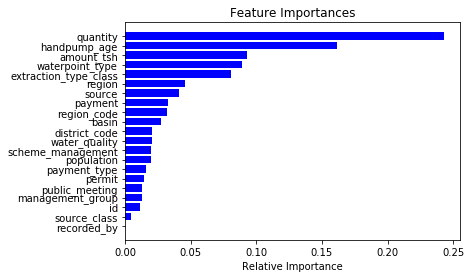

In [92]:
# exhibiting feature importance
features = X.columns
importances = rf_clf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()